In [194]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [195]:
words = open('names.txt', 'r').read().splitlines()

In [196]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']= 0
itos = {i:s for s,i in stoi.items()}

In [197]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [198]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [199]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [200]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [201]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
B1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
B2 = torch.randn(27, generator=g)
parameters = [C, W1, B1, W2, B2]

In [202]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [203]:
for p in parameters:
    p.requires_grad = True

In [204]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [205]:
lri = []
lossi = []
stepi = []

In [214]:
for i in range(200000):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())


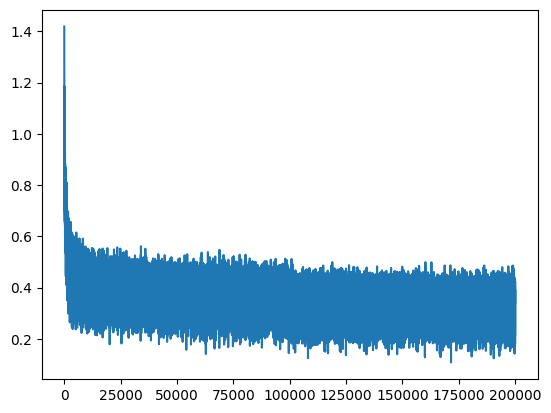

In [209]:
plt.plot(stepi, lossi)

In [212]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # (32, 100)
logits = h @ W2 + B2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1253, grad_fn=<NllLossBackward0>)

In [213]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # (32, 100)
logits = h @ W2 + B2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1208, grad_fn=<NllLossBackward0>)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))